# M77 Coursework: 3D "Pac-Man"
The following coursework is designed to test multiple components of the module sylabus; including 3D geometry, object detection, feature extraction and image manipulation.

Your task is to complete the below skeleton code to play a Pac-Man-esque game in 3D. You are allowed to utilise method discussed in the course, including feature extractors and deep learning approaches.

The aim of the coursework is to step through a 3D pointcloud of the old PhD lab at Swansea University. Several large spheres have been placed within the space, it is your job to move through the pointcloud in an automated fashion, detecting the location of the sphere and moving to the predicted 3D location. If you land close enough to a sphere it will be captured and removed from the pointcloud. 

You will need to decide what kinds of feature you want to use, extract these features and train a classifier to detect the spheres within an image. You can then use the functionality provided in the PacMan_functionality.py module to obtain the XYZ coordinates of the pixel you predict to be a sphere.


## Imports
Hre we will do our usual imports. I would recommend numpy, scipy, skimage, matplotlib and sklearn. If you wish to utilise the pointcloud processing toolkit you can do that as described in the handout. We will want to import our PacMan_functionality module as well.

In [1]:
import os
from PIL import Image   # https://www.pluralsight.com/guides/Importing-image-data-into-numpy-arrays
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TODO Sort out imports when CNN architecture is finished.
# TODO replace with import keras then replace from imports

from datetime import datetime

In [2]:
import PacMan_functionality as PacMan

## Game setup.
This cell will initialise the game world and add all of our spheres to the world. Do not edit the code here.

In [15]:
# Call startup_scene() to load the initial game scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [4]:
# View our pointcloud if we want
#v = pptk.viewer(global_cloud['Positions'], global_cloud['Colors']/255) # Fast, requires pptk
#PacMan.show_point_cloud(global_cloud) # Slow, requires matplotlib

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection.

In [13]:
# Get the training samples for both positive and negative patches

# Define dirs
pos_img_dir = 'TrainingImages/positives/'
neg_img_dir = 'TrainingImages/negatives/'

# go through negatives
neg_images = []
neg_labels = np.zeros( len( os.listdir(neg_img_dir) ) )

for filename in os.listdir(neg_img_dir):
    neg_images.append(np.array(Image.open(neg_img_dir + filename))/255 )  # Normal

print(f'Negative images shape: {np.shape(neg_images)}')

# go through positives
pos_images = []
pos_labels = np.ones( len( os.listdir(pos_img_dir) ) )

for filename in os.listdir(pos_img_dir):
    pos_images.append(np.array(Image.open(pos_img_dir + filename))/255 ) 

print(f'Negative images shape: {np.shape(pos_images)}\n')

# Concatenate the patches into a 4D numpy array (S*H*W*C), and create a label vector (S)

X = np.concatenate((neg_images, pos_images))
y = np.concatenate((neg_labels, pos_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=300,shuffle=True)

#Prove test and train data is split correctly
print(f'Training images shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing images shape: {X_test.shape}')
print(f'Testing labels shape: {y_test.shape}')

Negative images shape: (2600, 51, 51, 3)
Negative images shape: (308, 51, 51, 3)

Training images shape: (2326, 51, 51, 3)
Training labels shape: (2326,)
Testing images shape: (582, 51, 51, 3)
Testing labels shape: (582,)


## Train a classifier on the samples, this may require feature extraction on the patches
Depending on your desired apporach you may want to extract features on the training patches you have been given. These can then be used to train our desired classifier to detect the patches based not on the raw data, but on a representative feature descriptor. Several are talked about both in the lectures and labs. 

In [6]:
# Extract the features - maybe, might not be needed with representation learning approaches

In [7]:
# Train a classification model to perform binary classification of the patch into whether it contains a sphere.

# Architecture similar to Image Generator but without the augmentations
# Binary Classification CNN Architecture from 
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# TODO Try their imageGenerator and ensure it will recognise half spheres and that stuff
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), input_shape=(51, 51, 3)))   # Without this layer even the first sphere wouldnt be classified
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), input_shape=(51, 51, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))  # Prevent overfitting
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

model.save('Final_CNN.h5')    # Save model so it can be reloaded without retraining

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          1

In [8]:
# Just Load model for now
from tensorflow import keras

model = keras.models.load_model('Final_CNN.h5')

## Define my own functions that will be used
sliding_windows,
detect_spheres,
move_to_sphere are defined

In [9]:
# Define function sliding window
# This function goes through windows in an image and returns the x,y coordinates of the start
# of the windows containing spheres, and distance to sphere as a np array
def sliding_window_classifier( step_size, image, depth ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    result = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):

            window = image[y:y+window_size, x:x+window_size, :]

            #Normaly you predict on an array of value, but here since we want the (x,y) coordinates this is easier
            window = np.expand_dims(window, axis=0) # Adds first dimension to data (1,51,51,3) -> (1,51,51,3)
            prediction = model.predict( np.array( window ) )
            prediction = prediction[0][0] #  Unpack prediction [[1.]] -> 1

            # Only want patches we are 99.9% sure contain spheres
            if (prediction > 0.999):                
                print(f'Depth: {depth[y+25, x+25]}, Prediction {prediction}')
                plt.figure(figsize=(1,1))
                plt.title('Image')
                plt.imshow( window[0,:,:,:] )   
        
                # Add 'crosshair' to show middle pixel
                ax=plt.gca() 
                ax.spines['left'].set_position('center')
                ax.spines['bottom'].set_position('center')
                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                plt.show()

                # Spheres are always in the centre of the window.
                # Middle depth is the depth of the pixel in the centre of the sphere and window.
                middle_depth = depth[y+25, x+25]

                # Need these to be returned so we can move to the closest sphere.
                # x, y are now the coordinates of the centre of the sphere.
                result.append( (x+25, y+25, middle_depth) )

    # Results are np array with columns: x, y, depth
    # If length is 0 then no spheres were found
    return np.asarray(result)   

# Not necessary but nicely prints out the current viewpoints
def visualise_maps(image, mapx, mapy, mapz, depth):
    # Inputs can be full 160x240 or 51x51 in size
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

    ax[0].set_title('image')
    im0 = ax[0].imshow(image)
    #fig.colorbar(im, ax=ax[0])

    ax[1].set_title('mapx')
    im1 = ax[1].imshow(mapx, cmap='bwr')
    fig.colorbar(im1, ax=ax[1])

    ax[2].set_title('mapy')
    im2 = ax[2].imshow(mapy, cmap='bwr')
    fig.colorbar(im2, ax=ax[2])

    ax[3].set_title('mapz')
    im3 = ax[3].imshow(mapz, cmap='bwr')
    fig.colorbar(im3, ax=ax[3])

    ax[4].set_title('depth')
    im4 = ax[4].imshow(depth, cmap='bwr')
    fig.colorbar(im4, ax=ax[4])
    plt.show()
    print()

## Initialise our starting point in the game and get our first view into the scene
We should start the game at a position of XYZ = [0, 0, 0] and a camera angle of [0, 0, 0]. These variables can be updated once we find a sphere, or rotated when we don't find a sphere. We can then get our first image projected to the camera plane to start our game. 

In [16]:
# Initialise position and angle variable 
position = np.zeros([3])
angle = np.zeros([3])

In [11]:
# Get the image, XYZ maps and depth map of the current viewpoint into the scene


## Perform our loop, in which we will perform pixel-wise prediction on binary class label and then perform the correct action based on detection of spheres.
This will be the main bulk of your implementation, utilising the feature descriptors and trained models from the above cells. In each loop of the program we will want to:
-  Get current view into the scene
-  Extract patches from the scene
-  Extract features on the patches
-  Use the pretrained model to obtain class prediction probabilities
-  Identify if a sphere has been found in the scene
  -  If so, find the mapped XYZ location, move there and update the scene
  -  If not, rotate the camera in a bid to find the sphere


Start time:
17:20:36
Getting maps.... may take a while


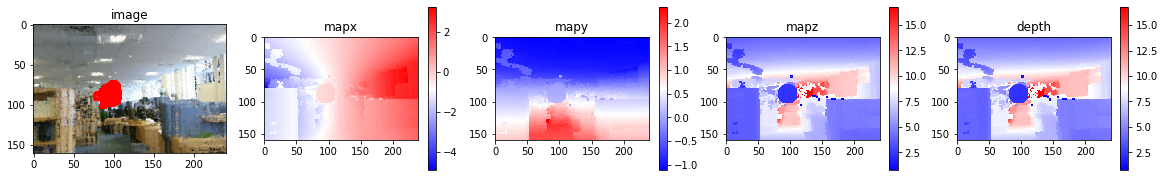


Depth: 2.3450562704232105, Prediction 0.9999905824661255


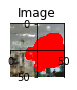

Depth: 2.320738942883683, Prediction 0.9999992847442627


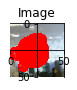

I am at position [0. 0. 0.]
I have found 0 out of 11 spheres!

I am now at position [-0.16517592  0.04936036  2.31432705]
I have found 1 out of 11 spheres!

Getting maps.... may take a while


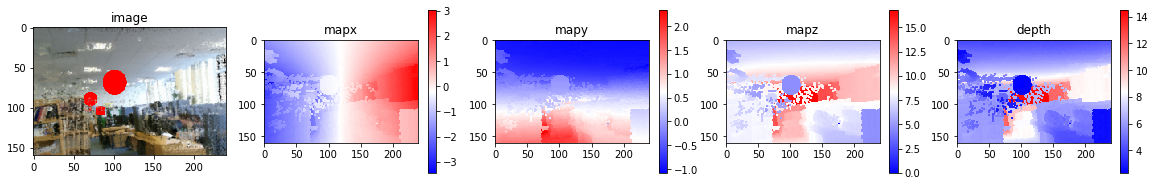


Depth: 2.365417274646692, Prediction 0.9999997615814209


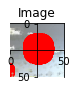

I am at position [-0.16517592  0.04936036  2.31432705]
I have found 1 out of 11 spheres!

I am now at position [-0.31316064 -0.03420023  4.67363141]
I have found 2 out of 11 spheres!

Getting maps.... may take a while


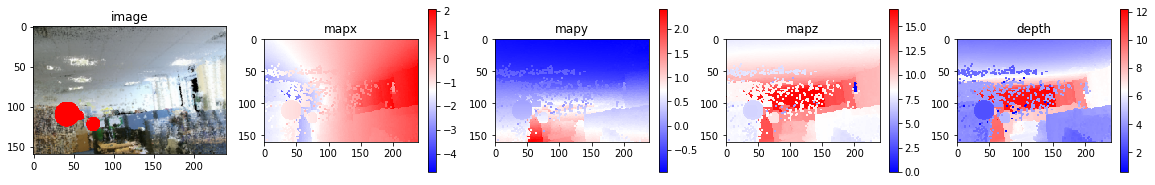


Depth: 2.450381421185578, Prediction 0.9998364448547363


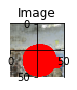

Depth: 2.431081645806323, Prediction 0.9999995231628418


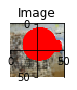

Depth: 2.4824074398887706, Prediction 0.9996423721313477


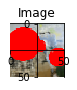

I am at position [-0.31316064 -0.03420023  4.67363141]
I have found 2 out of 11 spheres!

I am now at position [-0.92523327  0.22726996  7.01182695]
I have found 3 out of 11 spheres!

Getting maps.... may take a while


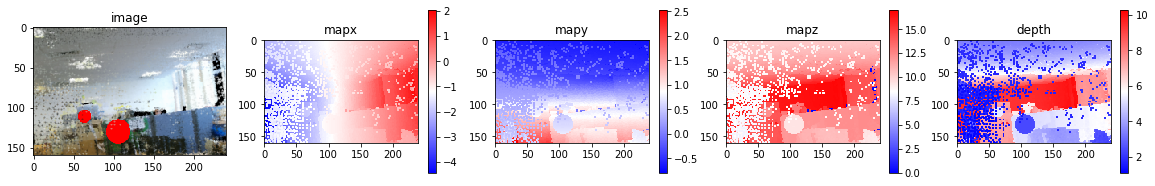


Depth: 2.406678481377616, Prediction 0.9999990463256836


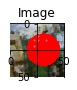

Depth: 2.4229292120032273, Prediction 0.9998119473457336


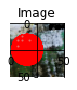

I am at position [-0.92523327  0.22726996  7.01182695]
I have found 3 out of 11 spheres!

I am now at position [-1.07148215  0.62442022  9.3810007 ]
I have found 4 out of 11 spheres!

Getting maps.... may take a while


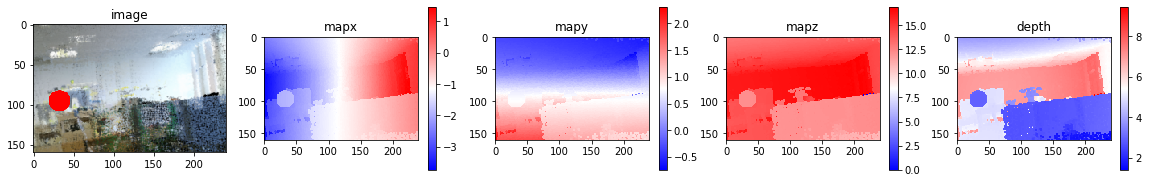


Depth: 2.9359123332002897, Prediction 0.9998732805252075


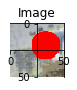

I am at position [-1.07148215  0.62442022  9.3810007 ]
I have found 4 out of 11 spheres!

I am now at position [-1.94373151  0.79750362 12.17900078]
I have found 5 out of 11 spheres!

Getting maps.... may take a while


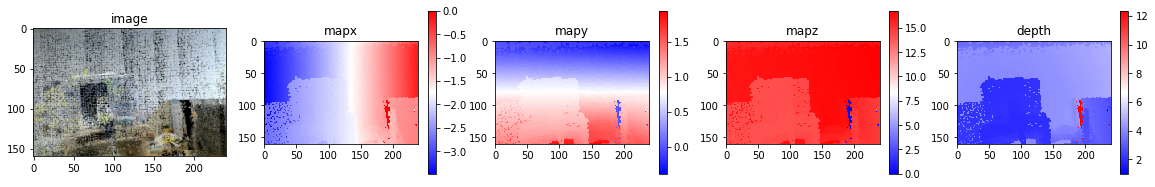


### No spheres found, rotating
Getting maps.... may take a while


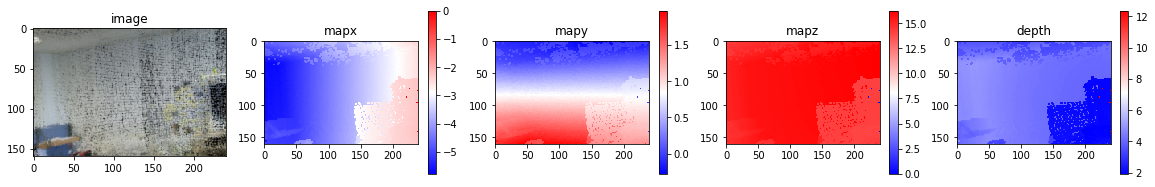


### No spheres found, rotating
Getting maps.... may take a while


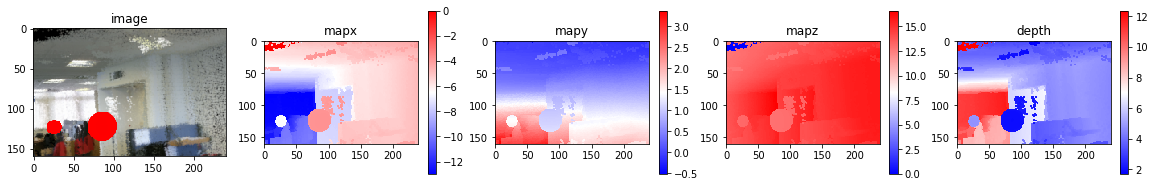


Depth: 1.9750547400220213, Prediction 0.9999988079071045


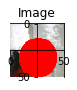

Depth: 2.034449909555986, Prediction 0.9996922016143799


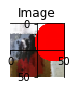

Depth: 1.9754648033582092, Prediction 0.9999994039535522


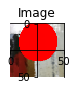

I am at position [-1.94373151  0.79750362 12.17900078]
I have found 5 out of 11 spheres!

I am now at position [-3.74171604  1.03448364 12.96126245]
I have found 6 out of 11 spheres!

Getting maps.... may take a while


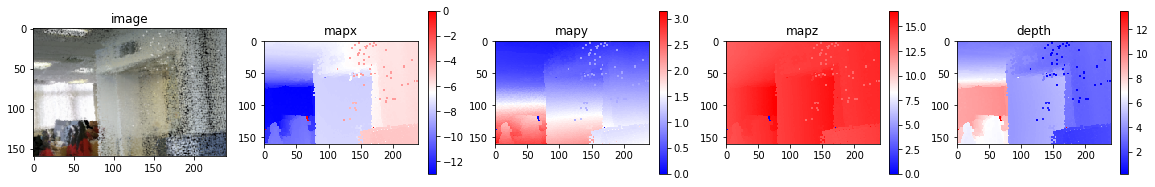


### No spheres found, rotating
Getting maps.... may take a while


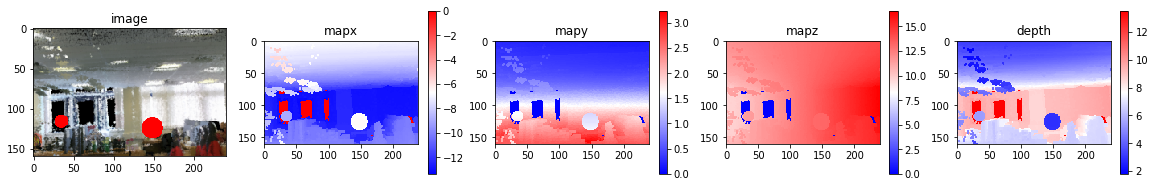


Depth: 2.8670187198449484, Prediction 0.9999954700469971


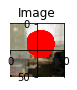

I am at position [-3.74171604  1.03448364 12.96126245]
I have found 6 out of 11 spheres!

I am now at position [-6.56096088  1.49306844 13.20896163]
I have found 7 out of 11 spheres!

Getting maps.... may take a while


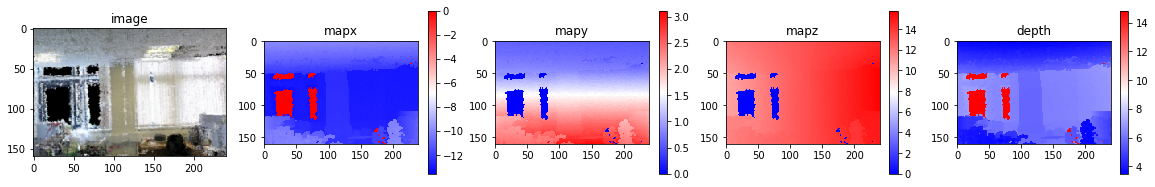


### No spheres found, rotating
Getting maps.... may take a while


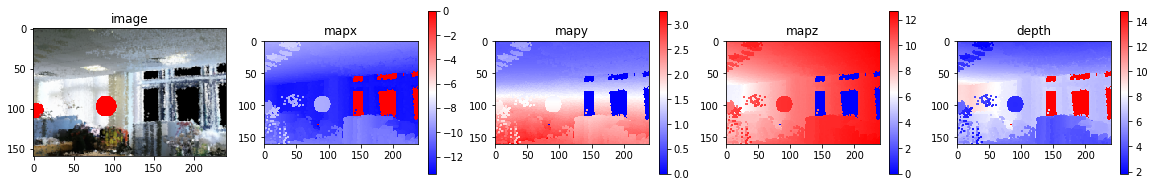


Depth: 2.888618379745225, Prediction 0.9999874830245972


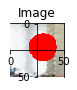

I am at position [-6.56096088  1.49306844 13.20896163]
I have found 7 out of 11 spheres!

I am now at position [-8.88185335  1.67165151 11.49849901]
I have found 8 out of 11 spheres!

Getting maps.... may take a while


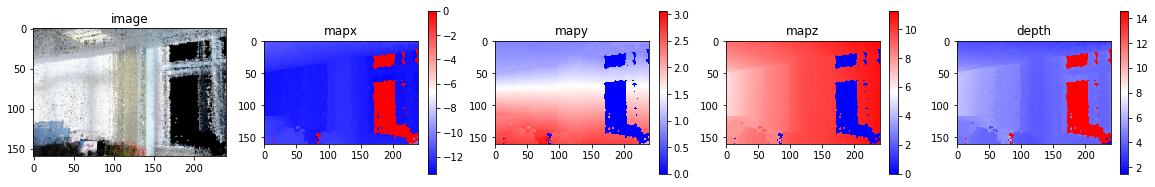


### No spheres found, rotating
Getting maps.... may take a while


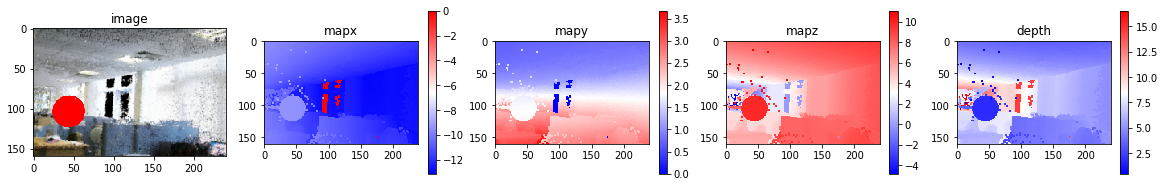


Depth: 1.8008881206367393, Prediction 0.9999997615814209


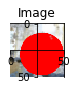

Depth: 1.8138278663672316, Prediction 0.9999963045120239


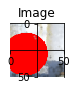

Depth: 1.8152804107518128, Prediction 0.9999973773956299


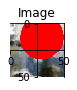

Depth: 1.8329031802612856, Prediction 0.9996283054351807


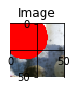

I am at position [-8.88185335  1.67165151 11.49849901]
I have found 8 out of 11 spheres!

I am now at position [-9.35497461  1.79559603  9.76529618]
I have found 9 out of 11 spheres!

Getting maps.... may take a while


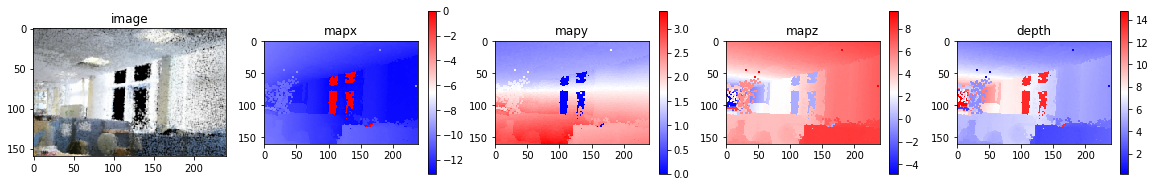


### No spheres found, rotating
Getting maps.... may take a while


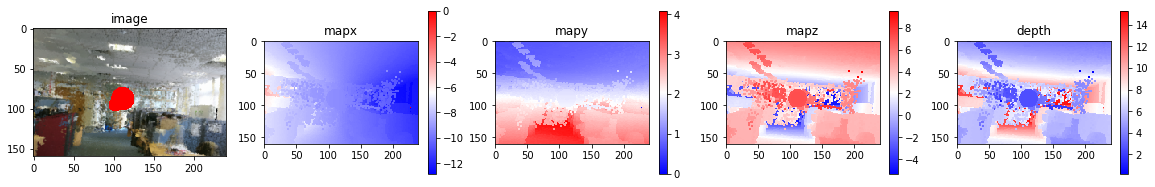


Depth: 2.5394117738271023, Prediction 0.9997041821479797


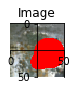

Depth: 2.505056540340904, Prediction 0.9999959468841553


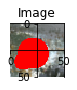

I am at position [-9.35497461  1.79559603  9.76529618]
I have found 9 out of 11 spheres!

I am now at position [-9.30127355  1.84967463  7.26139922]
I have found 10 out of 11 spheres!

Getting maps.... may take a while


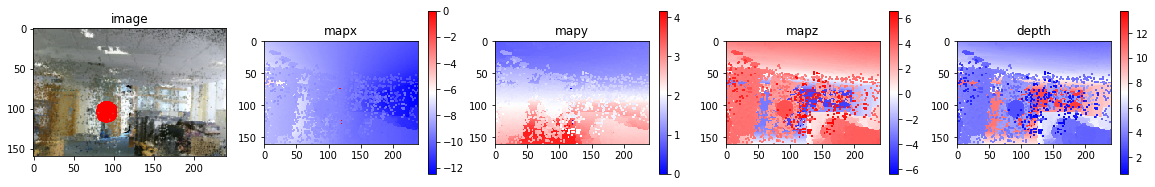


Depth: 2.7407786500245734, Prediction 0.9998648166656494


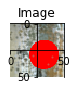

I am at position [-9.30127355  1.84967463  7.26139922]
I have found 10 out of 11 spheres!

I am now at position [-8.99785892  2.04243932  4.54429618]
I have found 11 out of 11 spheres!

End time:
17:42:24


In [21]:
# Call startup_scene() to load the initial game scene
global_cloud, spheres_collected = PacMan.startup_scene()

position = np.zeros([3])
angle = np.zeros([3])

print('Start time:')
print(datetime.now().strftime('%H:%M:%S') ) # Used to time the execution of the program.

window_step_size = 15   # How big the steps are between windows
rotation_angle = np.pi*1/6 # will rotate π/6 or 30°

while not np.all(spheres_collected): # While there are spheres to find
    # Get current image from viewpoint
    print('Getting maps.... may take a while')
    image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
    visualise_maps(image, mapx, mapy, mapz, depth)

    # Extract patches from the scene
    # Extract features from the patches    
    # Predict the probability of a pixel being a sphere, based on the patch
    # Use probabilities to find sphere coordinates in 3D
    sphere_windows = sliding_window_classifier(window_step_size, image, depth)

    # Update camera appropriately
    if ( len(sphere_windows) == 0):
        #rotate
        print('### No spheres found, rotating')
        angle = angle - np.asarray([0, rotation_angle, 0])   # numpy - is an elementwise operation 

    else:   # Spheres have been detected
        # Find the location of the window with lowest depth, which will show the closest sphere
        # sphere_windows has columns (x, y, depth)
        min_index = np.argmin( sphere_windows[:,2] )# Get the index of the closest sphere 
        x = int( sphere_windows[min_index, 0] )     # Get x location of start of sphere
        y = int( sphere_windows[min_index, 1] )    

        # Get spacial coordinates of new sphere
        newx = mapx[y, x] # I want Y, X not X, Y 
        newy = mapy[y, x] 
        newz = mapz[y, x] 

        # Move position and update scene
        print(f'I am at position {position}')
        print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')

        position = np.asarray([newx, newy, newz])
        print(f'I am now at position {position}')
        
        # Update scene
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')

print('End time:')
print(datetime.now().strftime('%H:%M:%S') ) # Used to time the execution of the program.